In [1]:
# 02_model_baselines.ipynb
# Train baseline models on the processed UCI diabetes cohort

import sys
import os
import numpy as np
import pandas as pd

repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

from src.train import split_data
from src.models_baseline import train_logreg, train_logreg_l1
import matplotlib.pyplot as plt

PROCESSED_PATH = "../data_processed/admissions_features.csv"

df = pd.read_csv(PROCESSED_PATH)
print("Shape:", df.shape)
df.head()

Shape: (101763, 25)


,encounter_id,patient_nbr,age_num,sex_female,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,comorb_obese,insulin_use,oral_med_count,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,label
0,2278392,8222157,5,1,1,41,0,1,0,0,...,0,0,0,False,False,True,False,False,False,0
1,149190,55629189,15,1,3,59,0,18,0,0,...,0,1,0,False,False,True,False,False,False,0
2,64410,86047875,25,1,2,11,5,13,2,0,...,0,0,1,True,False,False,False,False,False,0
3,500364,82442376,35,0,2,44,1,16,0,0,...,0,1,0,False,False,True,False,False,False,0
4,16680,42519267,45,0,1,51,0,8,0,0,...,0,1,1,False,False,True,False,False,False,0


In [2]:
label_col = "label"

X = df.drop(columns=[label_col, "encounter_id", "patient_nbr"])
y = df[label_col]

print("Feature matrix:", X.shape)
print("Positive rate (label=1):", y.mean())

Feature matrix: (101763, 22)
Positive rate (label=1): 0.11160244882717688


In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, label_col=label_col)

# Make sure we dropped ID columns from all splits
drop_cols = ["encounter_id", "patient_nbr", label_col]
X_train = X_train.drop(columns=[c for c in drop_cols if c in X_train.columns])
X_val   = X_val.drop(columns=[c for c in drop_cols if c in X_val.columns])
X_test  = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])

X_train.shape, X_val.shape, X_test.shape

((71234, 22), (15264, 22), (15265, 22))

In [4]:
def eval_model(model, X, y, set_name="val"):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)[:, 1]
    else:
        # fallback: use decision_function then squish
        scores = model.decision_function(X)
        # simple min-max scale as pseudo-prob
        probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)

    preds = (probs >= 0.5).astype(int)

    metrics = {
        "set": set_name,
        "AUROC": roc_auc_score(y, probs),
        "AUPRC": average_precision_score(y, probs),
        "Accuracy": accuracy_score(y, preds),
    }
    return metrics, preds, probs

In [5]:
logreg = train_logreg(X_train, y_train)
logreg_l1 = train_logreg_l1(X_train, y_train)
logreg_metrics_val, logreg_preds_val, logreg_probs_val = eval_model(
    logreg, X_val, y_val, "val"
)
logreg_metrics_test, logreg_preds_test, logreg_probs_test = eval_model(
    logreg, X_test, y_test, "test"
)

logreg_l1_metrics_val, logreg_l1_preds_val, logreg_l1_probs_val = eval_model(
    logreg_l1, X_val, y_val, "val"
)
logreg_l1_metrics_test, logreg_l1_preds_test, logreg_l1_probs_test = eval_model(
    logreg_l1, X_test, y_test, "test"
)

logreg_metrics_val, logreg_metrics_test

({'set': 'val',
  'AUROC': 0.6403924278903662,
  'AUPRC': 0.2095566347132954,
  'Accuracy': 0.6635875262054507},
 {'set': 'test',
  'AUROC': 0.6327079120496398,
  'AUPRC': 0.1955727366188706,
  'Accuracy': 0.6659679004258107})

In [6]:
results_val = pd.DataFrame([
    {"model": "LogReg_L2", **logreg_metrics_val},
    {"model": "LogReg_L1", **logreg_l1_metrics_val},
]).set_index("model")

results_test = pd.DataFrame([
    {"model": "LogReg_L2", **logreg_metrics_test},
    {"model": "LogReg_L1", **logreg_l1_metrics_test},
]).set_index("model")

print("Validation:")
display(results_val)

print("\nTest:")
display(results_test)

Validation:


,set,AUROC,AUPRC,Accuracy
model,,,,
LogReg_L2,val,0.640392,0.209557,0.663588
LogReg_L1,val,0.640415,0.209531,0.663653



Test:


,set,AUROC,AUPRC,Accuracy
model,,,,
LogReg_L2,test,0.632708,0.195573,0.665968
LogReg_L1,test,0.632714,0.195601,0.665575


Confusion matrix (test, L2 Logistic Regression):
[[9327 4234]
 [ 865  839]]


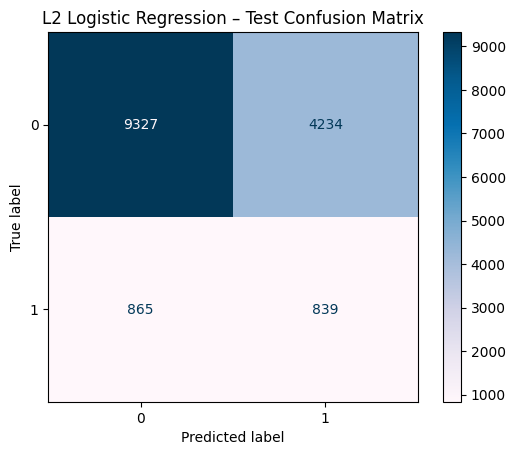

Classification report (test, L2 Logistic Regression):
              precision    recall  f1-score   support

           0      0.915     0.688     0.785     13561
           1      0.165     0.492     0.248      1704

    accuracy                          0.666     15265
   macro avg      0.540     0.590     0.516     15265
weighted avg      0.831     0.666     0.725     15265



In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

test_preds = logreg_preds_test
test_labels = y_test

cm = confusion_matrix(test_labels, test_preds)
print("Confusion matrix (test, L2 Logistic Regression):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d", cmap="PuBu")
plt.title("L2 Logistic Regression – Test Confusion Matrix")
plt.show()

print("Classification report (test, L2 Logistic Regression):")
print(classification_report(test_labels, test_preds, digits=3))

Confusion matrix (test, L1 Logistic Regression):
[[9342 4219]
 [ 865  839]]


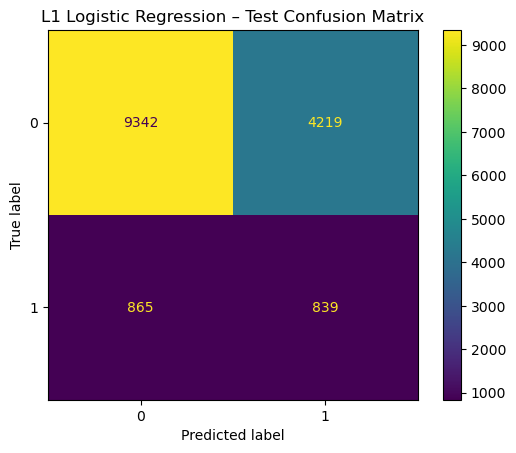

Classification report (test, L1 Logistic Regression):
              precision    recall  f1-score   support

           0      0.915     0.689     0.786     13561
           1      0.166     0.492     0.248      1704

    accuracy                          0.667     15265
   macro avg      0.541     0.591     0.517     15265
weighted avg      0.832     0.667     0.726     15265



In [9]:
cm_l1 = confusion_matrix(y_test, logreg_l1_preds_test)
print("Confusion matrix (test, L1 Logistic Regression):")
print(cm_l1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_l1, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title("L1 Logistic Regression – Test Confusion Matrix")
plt.show()

print("Classification report (test, L1 Logistic Regression):")
print(classification_report(y_test, logreg_l1_preds_test, digits=3))

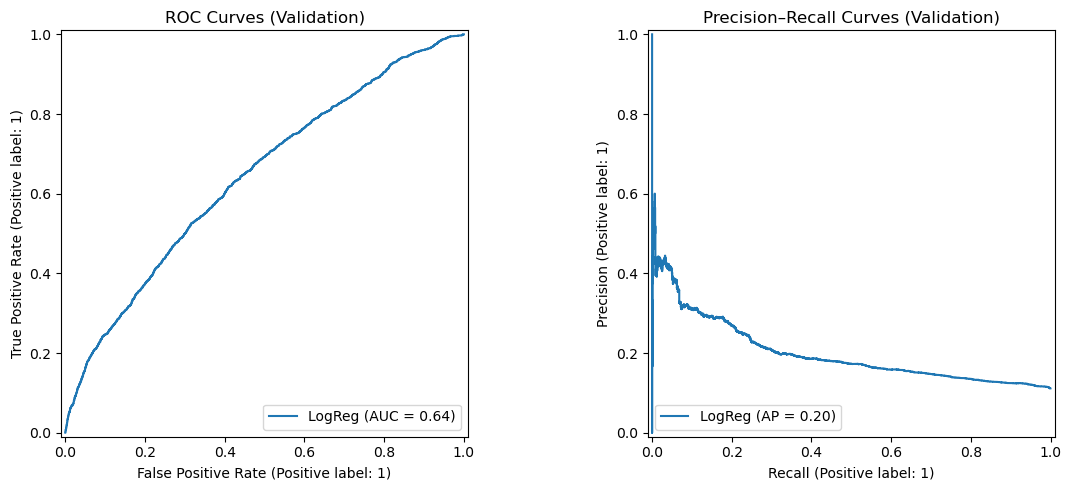

In [11]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(y_val, logreg_probs_val, ax=axes[0], name="LogReg")
axes[0].set_title("ROC Curves (Validation)")

PrecisionRecallDisplay.from_predictions(y_val, logreg_probs_val, ax=axes[1], name="LogReg")
axes[1].set_title("Precision–Recall Curves (Validation)")

plt.tight_layout()
plt.show()